<a href="https://colab.research.google.com/github/turagsarkar/Using-deep-transfer-learning-approch-for-Image-Based-Plant-leaf-Disease-Detection-model/blob/main/Image_Based_Plant_leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***`Using deep transfer learning approch for Image-Based Plant leaf Disease Detection model based on computer vision`***

***Dataset collection from***
https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset/data


In [3]:
#collcting data from google drive
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#libaray import
import keras
import numpy as np
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Sequential

In [5]:
#Load data using a Keras utility
batch_size = 16
img_height = 256
img_width = 256

In [6]:
data_dir='/content/drive/MyDrive/leaf/Train/Train'
data_dir_vs='/content/drive/MyDrive/leaf/Validation/Validation'
data_dir_ts='/content/drive/MyDrive/leaf/Test/Test'

In [7]:
#Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True)

Found 1322 files belonging to 3 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Powdery', 'Rust']


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_vs,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True)

Found 60 files belonging to 3 classes.


In [10]:
test_set=tf.keras.utils.image_dataset_from_directory(
    data_dir_ts,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True)

Found 150 files belonging to 3 classes.


TypeError: only integer scalar arrays can be converted to a scalar index

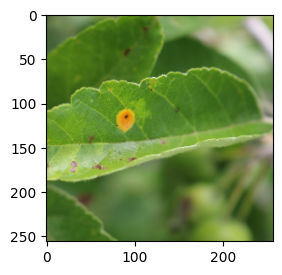

In [11]:
#Data Exploration and Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16, 3)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
print('\nTraining Dataset:', train_ds)
print('\nValidation Dataset:', val_ds)


Training Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [15]:
# Checking minimum and maximum pixel values in the train dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.021691177 0.9710785


In [21]:
train_ds =train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_set.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [19]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in val_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [22]:
# Checking minimum and maximum pixel values in the training dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in train_ds:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Training dataset', min_value)
print('\nMaximum pixel value in the Training dataset', max_value)


Minimum pixel value in the Training dataset 0.0

Maximum pixel value in the Training dataset 1.0


In [23]:
#data augmentation
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = 123),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = 123),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = 123)
    ]
)

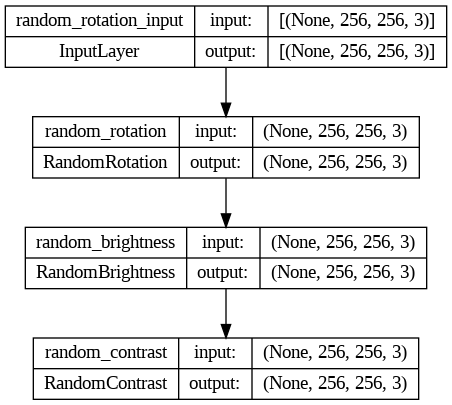

In [24]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

In [25]:

model= Sequential()

model.add(augmentation)

#Feature Layers
model.add(Conv2D(32,                  # Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input.
                    input_shape = (256,256,3) # Input image shape
                    ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(Dropout(0.3))

    # Flattening tensors
model.add(Flatten())

    # Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

    # Output Layer
model.add(Dense(3, activation = 'softmax')) # Classification layer

In [26]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('model_new.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [28]:
try:
    history = model.fit(
        train_ds, epochs = 1,
        validation_data = test_set,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

83/83 [==============================] - ETA: 0s - loss: 5.9793 - accuracy: 0.5356

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 915s 11s/step - loss: 5.9793 - accuracy: 0.5356 - val_loss: 24.7329 - val_accuracy: 0.3733


In [30]:
import numpy as np
preds = model.predict(train_ds)
train_loss, train_acc = model.evaluate(train_ds) # Obtaining Loss and Accuracy on the train dataset

print('\ntraining Loss: ', np.round(train_loss* 100), '%')
print('\ntraining Accuracy: ', np.round(train_acc * 100), '%')

83/83 [==============================] - 179s 2s/step - loss: 6.8439 - accuracy: 0.3253

training Loss:  684.0 %

training Accuracy:  33.0 %


In [31]:
import numpy as np
preds = model.predict(val_ds)
val_loss, val_acc = model.evaluate(val_ds)

print('\nValidation Loss: ',np.round( val_loss* 100), '%')
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

4/4 [==============================] - 9s 2s/step - loss: 6.8776 - accuracy: 0.3333

Validation Loss:  688.0 %

Validation Accuracy:  33.0 %


In [32]:
import numpy as np
preds = model.predict(test_set)
train_loss, train_acc = model.evaluate(test_set) # Obtaining Loss and Accuracy on the train dataset

print('\nTest Loss: ', train_loss)
print('\nTest Accuracy: ', np.round(train_acc * 100), '%')

10/10 [==============================] - 29s 2s/step - loss: 24.7329 - accuracy: 0.3733

Test Loss:  24.732891082763672

Test Accuracy:  37.0 %


In [33]:
for image_batch, labels_batch in test_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16, 3)


In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(labels_batch, axis=-1)

1/1 [==============================] - 3s 3s/step


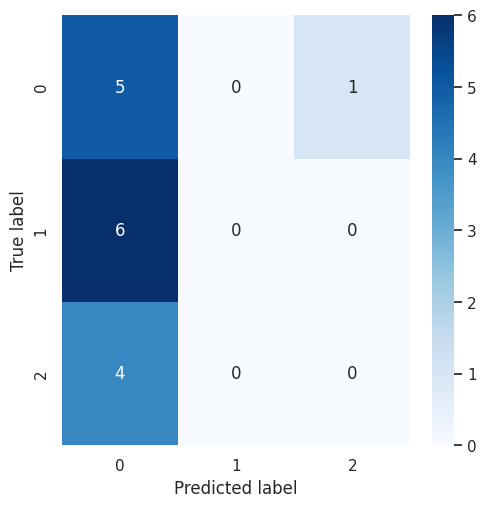

In [35]:
#confusion matrix
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

con_mat_df=tf.math.confusion_matrix(
    labels = label_id , predictions = predicted_id
)

figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       0.33      0.83      0.48         6
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         4

    accuracy                           0.31        16
   macro avg       0.11      0.28      0.16        16
weighted avg       0.12      0.31      0.18        16



In [37]:
#import gardio
#image = gardio.inputs.Image(shape=(256,256))
#label = gardio.outputs.Label(num_top_classes=5)

#gardio.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

In [29]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}


# TRANSFER LEARNING METHOD FOR BETTER PERFORMANCE

In [38]:
IMAGE_SIZE = [224, 224]

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)
prediction = Dense(3, activation='softmax')(x)

# create a model object
conv_base = Model(inputs=inception.input, outputs=prediction)

In [ ]:
conv_base.summary()

In [ ]:
num_classes = 3

model_new = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [ ]:
model_new.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
img_height,img_width=224,224
batch_size=32
train_dsnew = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_dsnew = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


In [ ]:
history = model_new.fit(train_dsnew
                    ,epochs=10,
                    validation_data=val_dsnew)

In [ ]:
from keras.applications.vgg16 import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

In [ ]:
conv_base.summary()

In [ ]:
from keras import Sequential
model_2 = Sequential()
model_2.add(augmentation)
model_2.add(conv_base)
model_2.add(Flatten())
model_2.add(Dense(256,activation='relu'))
model_2.add(Dense(1,activation='sigmoid'))

In [ ]:
model_2.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
history = model_2.fit(train_ds,epochs=10,validation_data=val_ds)

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

In [ ]:
from keras.models import Sequential

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
IMAGE_SIZE = [256, 256]

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(inception.output)

In [ ]:
folders=train_ds

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
 model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)